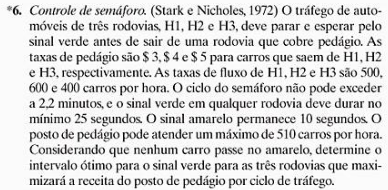

In [1]:
%pip install cplex
%pip install docplex

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
from docplex.mp.model import Model

# Criação do modelo com um nome descritivo
model = Model('Controle_Semaforo_Pedagio')

In [3]:
# --- Parâmetros extraídos do enunciado ---

# Identificadores
rodovias = [1, 2, 3]

# Dados financeiros e de fluxo
taxa_pedagio = {1: 3, 2: 4, 3: 5} # $/carro
fluxo_carros_hora = {1: 500, 2: 600, 3: 400} # carros/hora
capacidade_pedagio_hora = 510 # carros/hora

# Dados do ciclo do semáforo
max_ciclo_min = 2.2 # minutos
min_sinal_verde_s = 25 # segundos
sinal_amarelo_s = 10 # segundos

# --- Conversão de unidades para SEGUNDOS ---
segundos_por_hora = 3600.0
max_ciclo_s = max_ciclo_min * 60

# Fluxo de carros por segundo
fluxo_carros_s = {h: fluxo_carros_hora[h] / segundos_por_hora for h in rodovias}
# Capacidade do pedágio em carros por segundo
capacidade_pedagio_s = capacidade_pedagio_hora / segundos_por_hora

# Pré-cálculo da receita por segundo de sinal verde para cada rodovia
receita_por_segundo_verde = {h: taxa_pedagio[h] * fluxo_carros_s[h] for h in rodovias}

In [4]:
# 1. Variáveis de Decisão
# g[h] = duração do sinal verde em segundos para a rodovia h
g = model.continuous_var_dict(rodovias, name='G', lb=0)


# 2. Função Objetivo
# Maximizar a receita total por ciclo de semáforo
expressao_receita_ciclo = (receita_por_segundo_verde[h] * g[h] for h in rodovias)
receita_total_ciclo = model.sum(expressao_receita_ciclo)
model.maximize(receita_total_ciclo)


# 3. Restrições

# Restrição 1: Duração Máxima do Ciclo
# A soma de todos os sinais verdes e amarelos não pode exceder o máximo.
# g1+y1 + g2+y2 + g3+y3 <= max_ciclo  =>  g1+g2+g3 <= max_ciclo - 3*y
soma_verdes = model.sum(g[h] for h in rodovias)
restr_ciclo_logica = soma_verdes <= max_ciclo_s - len(rodovias) * sinal_amarelo_s
model.add_constraint(restr_ciclo_logica, ctname='duracao_max_ciclo')

# Restrição 2: Duração Mínima do Sinal Verde
for h in rodovias:
    restr_min_verde_logica = g[h] >= min_sinal_verde_s
    model.add_constraint(restr_min_verde_logica, ctname=f'duracao_min_g{h}')

# Restrição 3: Capacidade do Posto de Pedágio (Linearizada)
# A taxa média de chegada de carros não pode exceder a capacidade de atendimento.
# (Total de Carros no Ciclo) / (Duração Total do Ciclo) <= Capacidade_Pedágio
# Total_Carros <= Capacidade_Pedágio * Duração_Ciclo
# Sum(fluxo[h]*g[h]) <= cap_pedagio * (Sum(g[h]) + 3*y)
# ==> Sum((fluxo[h] - cap_pedagio) * g[h]) <= cap_pedagio * 3*y
expressao_capacidade_pedagio = model.sum((fluxo_carros_s[h] - capacidade_pedagio_s) * g[h] for h in rodovias)
lado_direito_capacidade = capacidade_pedagio_s * len(rodovias) * sinal_amarelo_s
restr_pedagio_logica = expressao_capacidade_pedagio <= lado_direito_capacidade
model.add_constraint(restr_pedagio_logica, ctname='capacidade_pedagio')

docplex.mp.LinearConstraint[capacidade_pedagio](-0.003G_1+0.025G_2-0.031G_3,LE,4.25)

In [5]:
# Aciona o solver para encontrar a solução
print("--- Resolvendo o modelo ---")
solucao = model.solve(log_output=True)

print('\n------ SOLUÇÃO ÓTIMA ------\n')
if solucao:
    receita_maxima_ciclo = model.objective_value
    print(f"Receita Máxima por Ciclo de Semáforo: ${receita_maxima_ciclo:,.2f}\n")

    print("--- Intervalos Ótimos para o Sinal Verde ---")
    tempo_total_ciclo = len(rodovias) * sinal_amarelo_s
    for h in rodovias:
        g_val = g[h].solution_value
        tempo_total_ciclo += g_val
        print(f"  - Rodovia H{h}: {g_val:,.2f} segundos")

    print(f"\nDuração Total do Ciclo: {tempo_total_ciclo:,.2f} segundos (Máximo permitido: {max_ciclo_s} s).")

else:
    print("Não foi possível encontrar uma solução.")

--- Resolvendo o modelo ---
Version identifier: 22.1.2.0 | 2024-12-10 | f4cec290b
CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
LP Presolve eliminated 5 rows and 3 columns.
All rows and columns eliminated.
Presolve time = 0.00 sec. (0.00 ticks)

------ SOLUÇÃO ÓTIMA ------

Receita Máxima por Ciclo de Semáforo: $58.97

--- Intervalos Ótimos para o Sinal Verde ---
  - Rodovia H1: 25.00 segundos
  - Rodovia H2: 52.00 segundos
  - Rodovia H3: 25.00 segundos

Duração Total do Ciclo: 132.00 segundos (Máximo permitido: 132.0 s).
